In [1]:
import torch
import torch.nn as nn
import scipy as sp
import numpy as np
from pau import PAU
import matplotlib.pyplot as plt

from pathlib import Path

data = Path('data/ds_5k_nmesh_200/')
data_model = data / 'model'

In [2]:
a, b = 0, 1

In [3]:
def build_net(layers):
    modules = []
    for i in range(len(layers)-1):
        modules.append(nn.Linear(layers[i], layers[i+1]))
        modules.append(PAU(initial_shape='relu'))

    net = nn.Sequential(*modules)
    opt = torch.optim.Adam(net.parameters())

    return net, opt

In [4]:
net, opt = build_net([2] + [100] + [1])

In [5]:
checkpoint = torch.load(data_model / '1000_2x100x1.model')

net.load_state_dict(checkpoint['net'])
print(checkpoint['epoch'])

1000


In [6]:
def trapezoidal_rule(a, b, npoints=100):
    int_p = torch.linspace(a,  b, npoints)
    int_w = torch.ones_like(int_p) * (b-a) / (npoints-1)
    int_w[[0, -1]] /= 2
    return int_p, int_w

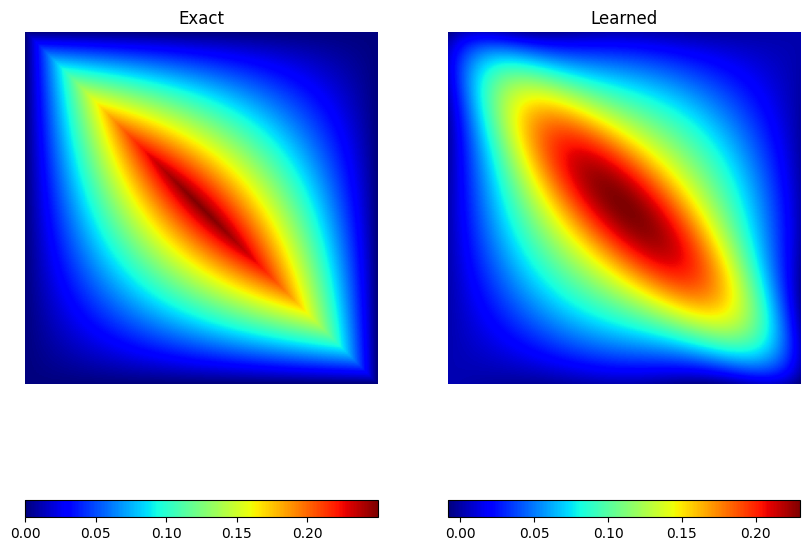

In [13]:
NT = 200
test_x, int_w = trapezoidal_rule(a, b, NT)
int_w = np.array(int_w)
tX, tY = torch.meshgrid(test_x, test_x, indexing='xy')
tXravel = tX.ravel()
tYravel = tY.ravel()
# test_input = torch.dstack().reshape(-1, 2)

learned_green = net(torch.dstack([tXravel, tYravel])).squeeze()

true_green = torch.zeros(NT*NT)
cond = tXravel < tYravel
true_green[cond] = tXravel[cond]*(1 - tYravel[cond])
true_green[~cond] = tYravel[~cond]*(1 - tXravel[~cond])

fig, ax = plt.subplots(ncols=2, figsize=(10,10))

p = ax[0].imshow(true_green.view(NT, NT), cmap='jet')
ax[0].axis('off')
ax[0].set_title('Exact')
fig.colorbar(p, ax=ax[0], location='bottom')

p = ax[1].imshow(learned_green.view(NT, NT).detach(), cmap='jet')
ax[1].axis('off')
ax[1].set_title('Learned')
fig.colorbar(p, ax=ax[1], location='bottom')

# plt.savefig('img/don_kernel_comparison_1kepoch_ds_5k_mesh_200.png')

plt.show()

# Eigenvalue Extraction

Let $\mu_1 \ge \mu_2 \ge \ldots$ be the eigenvalues of $G$ and $\psi_k$ be the corresponding eigenfunction. We know that
$$
    [G]_{ab} = G(x_a, x_b) = \sum_{k\ge 0} \frac{1}{\mu_k} \psi_k(x_a) \psi_k(x_b)
$$

In [14]:
green_matrix = learned_green.view(NT, NT)
green_matrix = 0.5 * (green_matrix + green_matrix.T)

In [15]:
with torch.no_grad():
    mu, v = sp.linalg.eigh(green_matrix)

v = v[:, np.argsort(abs(mu))[::-1]]

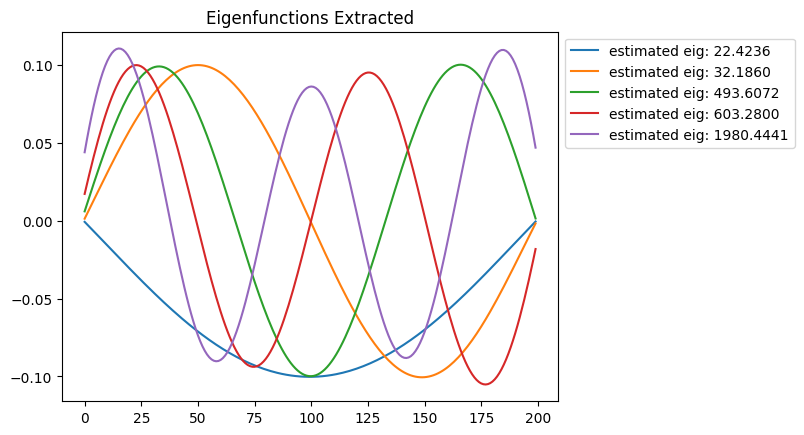

In [16]:
for c, f in zip(mu[:5], v.T[:5]):
    plt.plot(f, label=f'estimated eig: {1/abs(c):.4f}')
plt.title('Eigenfunctions Extracted')
plt.legend(bbox_to_anchor=(1,1))
# plt.savefig('img/don_kernel_size200x200_eigextraction5_epoch1000.png')
plt.show()

In [11]:
# torch.linalg.eigvals(learned_green.view(NT, NT))